In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import bloscpack as bp
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from preprocess_utilities import *
from registration_utilities import *

Setting environment for Precision WorkStation


No vtk


In [2]:
stack_moving = 'atlasV5'
detector_id = 15

In [3]:
# from sklearn.decomposition.pca import PCA

In [3]:
def find_best_jaccard(hm, hf):
    
    aligner = Aligner4({1: hf}, {1: hm}, labelIndexMap_m2f={1:1})

    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[1])

    gradients = compute_gradient({1: hf}, smooth_first=True)

    aligner.load_gradient(gradients=compute_gradient({1: hf}, smooth_first=True))

    T, scores = aligner.optimize(tf_type='rigid', lr1=1, lr2=0.1)

    # Ts = np.array(aligner.Ts)

    # plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
    # plt.title('rotational params');
    # plt.xlabel('Iteration');
    # plt.show();

    # plt.plot(Ts[:, [3,7,11]]);
    # plt.title('translation params');
    # plt.xlabel('Iteration');
    # plt.show();

    # print T.reshape((3,4))
    # plt.figure();
    # plt.plot(scores);
    # plt.show();

    # print T.reshape((3,4))

    transform_parameters = {'centroid_m': aligner.centroid_m,
                           'centroid_f': aligner.centroid_f,
                           'domain_f_origin_wrt_wholebrain': np.zeros((3,)),
                           'domain_m_origin_wrt_wholebrain': np.zeros((3,)),
                           'parameters': T}

    hm_aligned, hm_aligned_origin_wrt_hf = transform_volume_by_alignment_parameters(hm.astype(np.int), 
                                                                                    origin=np.array((0,0,0)), 
                                                                                    transform_parameters=transform_parameters)

    hm_aligned = crop_and_pad_volume(hm_aligned, in_origin=hm_aligned_origin_wrt_hf, out_bbox=hf)
    
    return jaccard_masks(hm_aligned, hf, wrt_min=False)

In [4]:
#metrics_allStacks_allStructures_allLevels = defaultdict(lambda: defaultdict(dict))
metrics_allStacks_allStructures = defaultdict(lambda: defaultdict(dict))

for stack_fixed in ['MD589']:
# for stack_fixed in ['MD585','MD589','MD594']:
        
#     for structure in all_known_structures_sided:
    for structure in ['6N_R']:
        
        try:

            stack_spec = dict(name=stack_fixed,
                       vol_type='annotationAsScore',
                       detector_id=None,
                       prep_id=None,
                       structure=None,
                       resolution='down32')

            ann_vol, ann_vol_origin_wrt_wholebrain_down32Resol = \
            DataManager.load_original_volume_v2(stack_spec, structure=structure, 
                                                bbox_wrt=None,
                                                return_origin_instead_of_bbox=True)        
            ####################

            stack_spec = dict(name=stack_fixed,
                               vol_type='score',
                               detector_id=15,
                               prep_id=2,
                               structure=None,
                               resolution='down32')

            alignedAtlas_vol_m2f = DataManager.load_transformed_volume(stack_m=stack_moving, stack_f=stack_fixed,
                                                            prep_id_f=2,
                                                            detector_id_f=detector_id,
                                                            warp_setting=17, 
                                                           structure=structure)

            alignedAtlas_vol_m2f_origin_wrt_wholebrain_down32Resol = \
                DataManager.get_domain_origin(stack=stack_fixed, domain='brainstem').astype(np.int)            

            ######################
            
            hf = ann_vol > 0

#             xyzs = np.array(np.where(hf))[[1,0,2]]
#             pca = PCA(n_components=3)
#             xyzs_transformed = pca.fit_transform(xyzs.T)
#             principle_axes = pca.components_
#             annotation_centroid = pca.mean_
#             principal_axes_lengths_down32 = xyzs_transformed.max(axis=0) - xyzs_transformed[:, 0].min(axis=0)
#             principal_axes_lengths_um = principal_axes_lengths_down32 * convert_resolution_string_to_voxel_size(resolution='down32', stack=stack_fixed)
#             print stack_fixed, structure
#             print 'principal_axes_lengths_um =', principal_axes_lengths_um
#             del xyzs, xyzs_transformed, pca
            
            hm = crop_and_pad_volume(alignedAtlas_vol_m2f, 
                                     in_origin = alignedAtlas_vol_m2f_origin_wrt_wholebrain_down32Resol - ann_vol_origin_wrt_wholebrain_down32Resol,
                                    out_bbox=(0, hf.shape[1]-1, 0, hf.shape[0]-1, 0, hf.shape[2]-1))
            
#             display_volume_sections(hf, start_level=0, direction='z')
#             display_volume_sections(hm, start_level=0, direction='z')
            
            annVol_centroid_wrt_wholebrain_down32Resol = compute_centroid_3d(hf)
        
#             corr = np.corrcoef(hm.flatten(), hf.flatten())[0,1]
            mask = (hm > 0) | (hf > 0)
            corr = np.corrcoef(hm[mask].flatten(), hf[mask].flatten())[0,1]
        
#             mean_diff = np.sqrt(np.mean(np.abs(hm[mask] - hf[mask])**2))
            mean_diff = np.mean(np.abs(hm[mask].astype(np.float) - hf[mask].astype(np.float)))
            
            print 'corr =', corr, 'mean_diff =', mean_diff
            
#             metrics_allStacks_allStructures[stack_fixed][structure] = {'corr': corr, 'mean_diff': mean_diff}
                
            for level in np.arange(0.1, 1, 0.1):
                
                alignedAtlas_centroid_wrt_wholebrain_down32Resol = compute_centroid_3d(hm > level)
                
                centroid_diff_vec_down32 = annVol_centroid_wrt_wholebrain_down32Resol - alignedAtlas_centroid_wrt_wholebrain_down32Resol
#                 centroid_diff_percentage = np.dot(principle_axes, centroid_diff_vec_down32) / principal_axes_lengths_down32
                centroid_diff_norm_down32 = np.linalg.norm(centroid_diff_vec_down32)
                centroid_diff_percentage = centroid_diff_norm_down32 / get_structure_length_at_direction(hf, centroid_diff_vec_down32)
                
                centroid_diff_um = np.linalg.norm(centroid_diff_vec_down32) * convert_resolution_string_to_voxel_size(resolution='down32', stack=stack_fixed)
                               
#                 jac = jaccard_masks(hm > level, hf, wrt_min=False)
#                 best_jac = find_best_jaccard(hm > level, hf)
                
#                 print stack_fixed, structure, 'level =', float(level), 'jaccard_min =', jac, 'corr =', corr, 'centroid_diff =', centroid_diff_um, 'um'
                print 'level =', float(level)
#                 print 'jaccard =', jac, 'best =', best_jac
                print 'centroid_diff_vec_um =', centroid_diff_um, 'um'
                print 'centroid_diff_percentage =', centroid_diff_percentage
    
                metrics_allStacks_allStructures_allLevels[stack_fixed][structure][float(level)] = \
        {'corr': corr, 
         'mean_diff': mean_diff, 
         'jac':jac, 
         'best_jac': best_jac,
         'centroid_diff_um': centroid_diff_um, 
         'centroid_diff_percentage':centroid_diff_percentage
        }
            
#             print '\n'
            
        except Exception as e:
            sys.stderr.write("Cannot evaluate structure %s: %s\n" % (structure, e))
            continue

rm -rf "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_6N_R_origin.txt" && mkdir -p "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_6N_R_origin.txt" "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_6N_R_origin.txt"
1


Cannot evaluate structure 6N_R: /home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_6N_R_origin.txt not found.


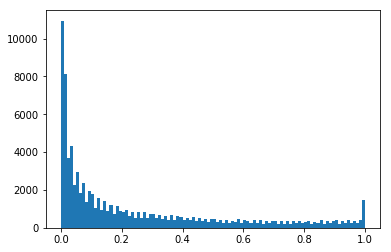

In [99]:
plt.hist(np.abs(hm[mask] - hf[mask]), bins=100);

In [14]:
metrics_allStacks_allStructures_allLevels.default_factory = None

In [15]:
fp = '/home/yuncong/CSHL_registration_metrics/metrics_allStacks_allStructures_allLevels.pkl'
create_parent_dir_if_not_exists(fp)
save_pickle(metrics_allStacks_allStructures_allLevels, fp)

In [5]:
fp = '/home/yuncong/CSHL_registration_metrics/metrics_allStacks_allStructures_allLevels.pkl'
metrics_allStacks_allStructures_allLevels = load_pickle(fp)

## Compute centroid difference

In [56]:
diff_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_um'] for l, v in x_all_l.iteritems()]) for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in metrics_allStacks_allStructures_allLevels.iteritems()}

In [57]:
np.median([y for x in diff_all_stacks_all_structures.values() for y in x.values()])

62.60149319399443

In [58]:
# Only show motor nuclei (for use together with CHAT figure).

diff_all_stacks_all_structures_motor_nuclei_only = {stack: {s: data_all_structures[s] 
                                                            for s in ['5N_L', '5N_R', '6N_L', '6N_R',
                                      '7N_L', '7N_R', 'Amb_L', 'Amb_R',
                                      '10N_L', '10N_R', '12N']} 
 for stack, data_all_structures in diff_all_stacks_all_structures.iteritems()}

In [62]:
pd.DataFrame(diff_all_stacks_all_structures_motor_nuclei_only).to_csv(\
'/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_vs_expert_annotation/measurements/centroid_difference_3d_wrt_human_annotation_um_motor_nuclei_only.csv')

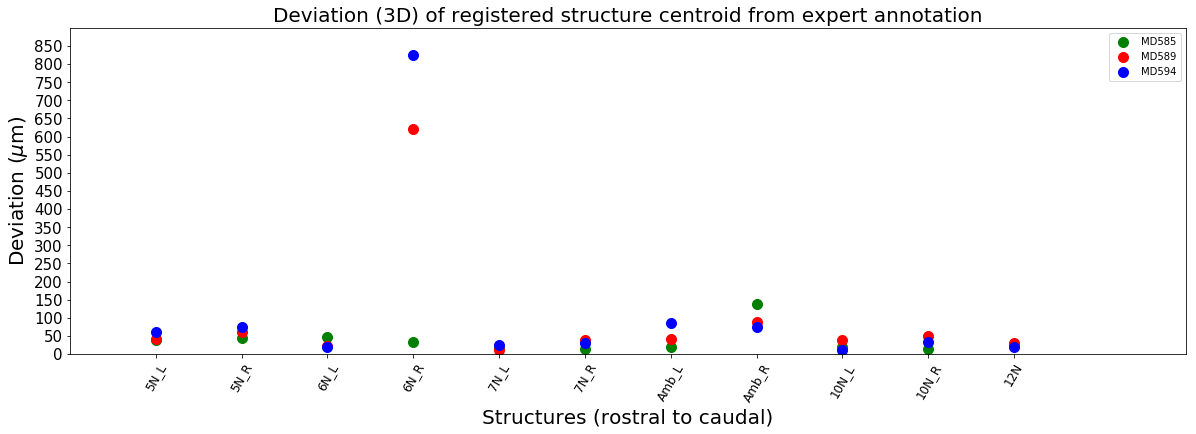

In [73]:
plot_by_stack_by_structure(diff_all_stacks_all_structures, 
                           structures=['5N_L', '5N_R', '6N_L', '6N_R',
                                      '7N_L', '7N_R', 'Amb_L', 'Amb_R',
                                      '10N_L', '10N_R', '12N'],
                           yticks=np.arange(0, 900, 50), 
                           yticklabel_fmt='%d',
                           ylabel='Deviation ($\mu$m)',
                           xlabel='Structures (rostral to caudal)',
                          title='Deviation (3D) of registered structure centroid from expert annotation',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

In [ ]:
# Show all structures

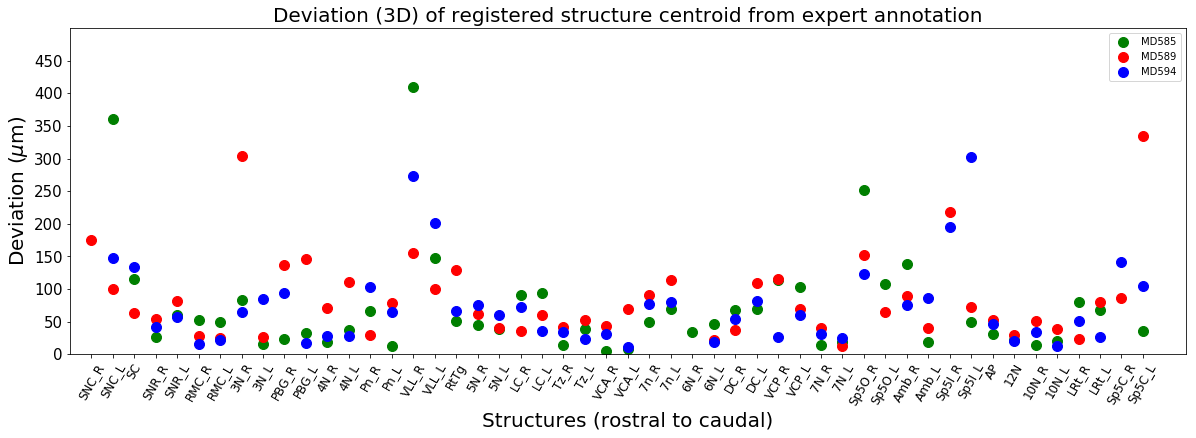

In [68]:
plot_by_stack_by_structure(diff_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           yticks=np.arange(0, 500, 50), 
                           yticklabel_fmt='%d',
                           ylabel='Deviation ($\mu$m)',
                           xlabel='Structures (rostral to caudal)',
                          title='Deviation (3D) of registered structure centroid from expert annotation',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

In [63]:
pd.DataFrame(diff_all_stacks_all_structures).to_csv(\
'/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_vs_expert_annotation/measurements/centroid_difference_3d_wrt_human_annotation_um.csv')

## Measure centroid distance normalized by structure size

In [11]:
diffperc_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_percentage'] for l, v in x_all_l.iteritems()]) for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in metrics_allStacks_allStructures_allLevels.iteritems()}

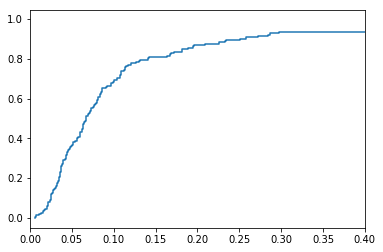

In [12]:
sorted_data = np.sort(([y for x in diffperc_all_stacks_all_structures.values() for y in x.values()]))
plt.step(sorted_data, np.arange(sorted_data.size)/float(len(sorted_data)));  # From 0 to the number of data points-1
plt.xlim([0, 0.4]);
# plt.step(sorted_data[::-1], np.arange(sorted_data.size))  # From the number of data points-1 to 0

In [13]:
np.median([y for x in diffperc_all_stacks_all_structures.values() for y in x.values()])

0.06693369811432645

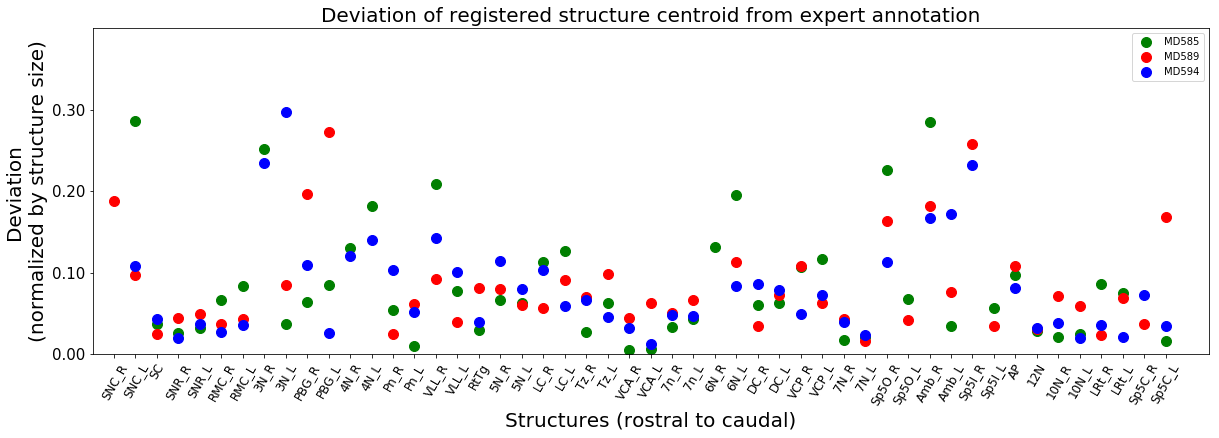

In [24]:
plot_by_stack_by_structure(diffperc_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           yticks=np.arange(0, 0.35, 0.1), 
                                                      xlabel='Structures (rostral to caudal)',
                           ylabel='Deviation \n(normalized by structure size)',
                          title='Deviation of registered structure centroid from expert annotation',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});

## Measure voxel value difference 

In [22]:
meandiff_all_stacks_all_structures = \
{stack: {s: x_all_levels[0.5]['mean_diff']
         for s, x_all_levels in x_all_s_all_levels.iteritems()}
 for stack, x_all_s_all_levels in metrics_allStacks_allStructures_allLevels.iteritems()}

In [23]:
np.median([y for x in meandiff_all_stacks_all_structures.values() for y in x.values()])

0.23508416238474567

In [28]:
import pandas as pd

In [29]:
pd.DataFrame(meandiff_all_stacks_all_structures)

,MD585,MD589,MD594
10N_L,0.201910,0.221000,0.204820
10N_R,0.189155,0.255828,0.182745
12N,0.174232,0.200126,0.209392
3N_L,0.234733,0.229255,0.397556
3N_R,0.355193,0.551430,0.378164
4N_L,0.248656,0.196700,0.225911
4N_R,0.227514,0.212803,0.213509
5N_L,0.213285,0.236133,0.276473
5N_R,0.234497,0.254532,0.224917
6N_L,0.273988,0.222342,0.249047


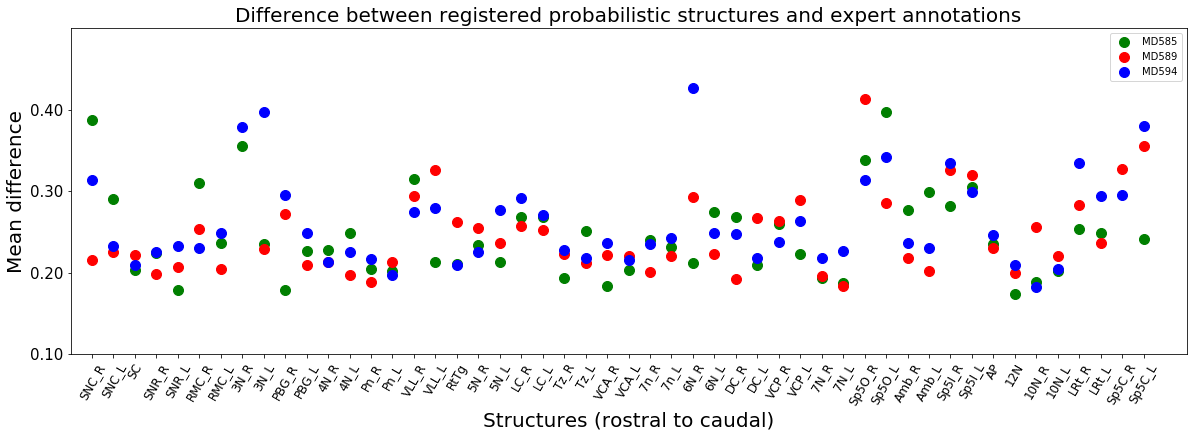

In [26]:
plot_by_stack_by_structure(meandiff_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           yticks=np.arange(0.1, 0.5, 0.1), 
                            xlabel='Structures (rostral to caudal)',
                           ylabel='Mean voxel value difference',
                          title='Difference between registered probabilistic structures and expert annotations',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)});